# Affixal Rivalry between -ed and -y in English
This is a end of semester project for the class Experimental Morphology at the University Paris Cite'. 

The aim of this project is to investigate the affixal rivalry between the ending -ed and -y in English. According to the paper by Nagano (2022), there exists a purely semantic affixal rivalry between these two endings in the denominalized adjectives, created from English concrete nouns. This project aims to investigate the findings from Nagano (2022), by using the distributional methodology.

There are two experiments in this project. The first one is to compare the difference vectors between the two affixes to see if they are semantically comparable or not. The second experiment is to train a classifier on these difference vectors, then test the classifier on unseen data, in this case the data from UniMorph. 

In [110]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api


In [111]:
# Import the Word2Vec model
wv = api.load('word2vec-google-news-300')

# Define a vectorize function
def vectorize(tokens):
    vectors = []
    for token in tokens:
        if token in wv:
            vectors.append(wv[token])
        else:
            vectors.append(None)
    return vectors

In [112]:
# Creating the dataframe for training data from Nagano (2022):
column_names = ['ROOT', 'DERIV', 'AFFIX']
train_data = pd.read_csv('nagano-data.tsv', sep='\t', names=column_names)
print(train_data)

# Vectorize the training data
train_data['ROOT_VECTOR'] = train_data['ROOT'].apply(lambda x: vectorize(x.split()))
train_data['DERIV_VECTOR'] = train_data['DERIV'].apply(lambda x: vectorize(x.split()))
train_data['AFFIX'] = train_data['AFFIX'].replace({'-ed': 0, '-y': 1})
print(train_data)

     ROOT    DERIV AFFIX
0     leg   legged   -ed
1     leg    leggy    -y
2    bone    boned   -ed
3    bone    boney    -y
4   price   priced   -ed
..    ...      ...   ...
71    oil     oily    -y
72  spice   spiced   -ed
73  spice    spicy    -y
74  sugar  sugared   -ed
75  sugar   sugary    -y

[76 rows x 3 columns]
     ROOT    DERIV  AFFIX                                        ROOT_VECTOR  \
0     leg   legged      0  [[0.00090789795, 0.12011719, 0.021972656, -0.2...   
1     leg    leggy      1  [[0.00090789795, 0.12011719, 0.021972656, -0.2...   
2    bone    boned      0  [[-0.21191406, 0.049072266, -0.11328125, -0.03...   
3    bone    boney      1  [[-0.21191406, 0.049072266, -0.11328125, -0.03...   
4   price   priced      0  [[0.14160156, -0.02709961, -0.18457031, 0.1748...   
..    ...      ...    ...                                                ...   
71    oil     oily      1  [[-0.13964844, 0.06225586, -0.27929688, 0.0639...   
72  spice   spiced      0  [[-0.01635

In [113]:
# Define a function to calculate the difference vector between the root and the derivational form:
def difference_vector(v1, v2):
    return np.subtract(v1, v2)

# Defining the function to calculate the cosine similarity between two vectors:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Calculating the difference vector between the root and the derivational form:
train_data['DIFFERENCE_VECTOR'] = train_data.apply(lambda x: difference_vector(x['ROOT_VECTOR'][0], x['DERIV_VECTOR'][0]), axis=1)

# Separate the data into two groups: -ed and -y:
train_data_ed = train_data[train_data['AFFIX'] == 0].reset_index(drop=True)
train_data_y = train_data[train_data['AFFIX'] == 1].reset_index(drop=True)

# Calculating the cosine similarity between the difference vector of -ed and -y:
new_train_data = pd.concat([train_data_ed['ROOT'], train_data_ed['DIFFERENCE_VECTOR']], axis=1)
new_train_data = new_train_data.rename(columns={'DIFFERENCE_VECTOR': 'DIFFERENCE_VECTOR_ed'})
new_train_data = pd.concat([new_train_data, train_data_y['DIFFERENCE_VECTOR']], axis=1)
new_train_data = new_train_data.rename(columns={'DIFFERENCE_VECTOR': 'DIFFERENCE_VECTOR_y'})
new_train_data['COSINE_SIMILARITY'] = new_train_data.apply(lambda x: cosine_similarity(x['DIFFERENCE_VECTOR_ed'], x['DIFFERENCE_VECTOR_y']), axis=1)
new_train_data = new_train_data.drop(['DIFFERENCE_VECTOR_ed', 'DIFFERENCE_VECTOR_y'], axis=1)
print(new_train_data)
print(f"The average similarity between the two affixes is: {new_train_data['COSINE_SIMILARITY'].mean()}")

       ROOT  COSINE_SIMILARITY
0       leg           0.526988
1      bone           0.602122
2     price           0.537156
3       wit           0.264876
4     curve           0.628152
5      head           0.354714
6     brain           0.603593
7     cheek           0.448141
8   feather           0.641470
9      hand           0.227643
10     head           0.354714
11      hip           0.482956
12    mouth           0.506514
13     nose           0.364511
14     skin           0.517622
15    tooth           0.620628
16     edge           0.395138
17     loft           0.324167
18     room           0.246554
19    shape           0.319353
20    taste           0.323992
21     fish           0.202100
22     leaf           0.354984
23     rock           0.445634
24     sand           0.314394
25    stone           0.345706
26    water           0.352573
27      air           0.181804
28    cloud           0.606249
29     dust           0.459283
30      ice           0.322265
31     m

In [114]:
# We can also visualize the difference vectors of the two affixes:
difference_vectors_ed = np.array(train_data_ed['DIFFERENCE_VECTOR'].tolist())
difference_vectors_y = np.array(train_data_y['DIFFERENCE_VECTOR'].tolist())

# Averaging the difference vectors of -ed and -y:
average_difference_vector_ed = np.mean(difference_vectors_ed, axis=0)
average_difference_vector_y = np.mean(difference_vectors_y, axis=0)
print(average_difference_vector_ed.shape)
# Similarity between the average difference vectors of -ed and -y:
similarity = cosine_similarity(average_difference_vector_ed, average_difference_vector_y)
print(f"The similarity between the average difference vectors of -ed and -y is: {similarity}")

(300,)
The similarity between the average difference vectors of -ed and -y is: 0.5349239110946655


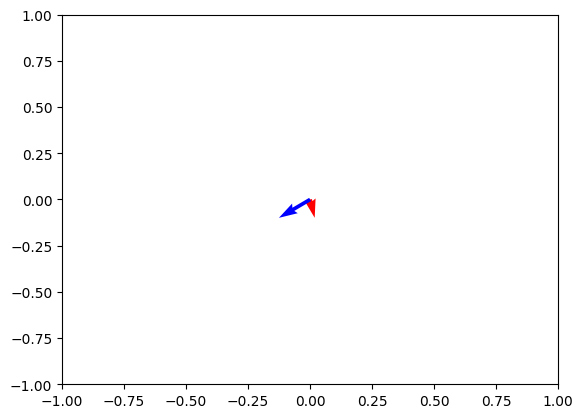

In [115]:
# Plotting the difference vectors of -ed and -y into 2D:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

reduced_ed = pca.fit_transform(difference_vectors_ed)
reduced_y = pca.fit_transform(difference_vectors_y)

reduced_ed = np.mean(reduced_ed, axis=0)
reduced_y = np.mean(reduced_y, axis=0)

plt.figure()
ax = plt.gca()
ax.quiver([0, 0], [0, 0], [reduced_ed[0], reduced_y[0]], [reduced_ed[1], reduced_y[1]], color=['r', 'b'])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.draw()
plt.show()

 

In [116]:
# Importing the UniMorph dataset
column_names = ['ROOT', 'DERIV', 'PROCESS', 'AFFIX']
data = pd.read_csv('UniMorph-Eng/eng/eng.derivations.tsv', sep='\t', names = column_names)

# We only look at N:ADJ and -ed; -y
data = data[(data['PROCESS'] == 'N:ADJ') & ((data['AFFIX'] == '-ed') | (data['AFFIX'] == '-y'))]
data = data.drop(['PROCESS',], axis=1)
print(data)


                ROOT          DERIV AFFIX
16           abandon      abandoned   -ed
31            abatis       abatised   -ed
119            abort        aborted   -ed
186         abstract     abstracted   -ed
271             crag         craggy    -y
...              ...            ...   ...
224929          wuss          wussy    -y
224949  significator  significatory    -y
224957    combinator    combinatory    -y
224962          hock         hocked   -ed
225077       lattice       latticed   -ed

[4192 rows x 3 columns]
